In [1]:
# Import the SDK and the client module
from label_studio_sdk import Client
from label_studio_sdk import Project
from label_studio_sdk.data_manager import Column, Filters, Operator, Type
from datetime import datetime
import json 
from IPython.display import Image as displayImage
from PIL import Image
import os

# Define the URL where Label Studio is accessible and the API key for your user account
LABEL_STUDIO_URL = 'http://localhost:8080'
API_KEY = '451682410d6f6de172f36f4b49729792f2875094'


# Connect to the Label Studio API and check the connection
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
ls.check_connection()



{'status': 'UP'}

In [2]:
projects=ls.get_projects()
print("Total Projects present: "+str(len(projects)))
print("Select a project from below:")
for idx,p in enumerate(projects):
    print(str(idx+1)+'.'+p.title)
selProjectNum=int(input("Select a project..."))-1

project=projects[selProjectNum]


Total Projects present: 4
Select a project from below:
1.LalCovid
2.CovidLal
3.CovidforLalPath
4.OCR & NER for Lab Reports


Select a project... 1


In [3]:
#get the last annotated task
filters = Filters.create(Filters.OR, [
    Filters.item(
        Column.completed_at,
        Operator.IN,
        Type.Datetime,
        Filters.value(
            datetime(2021, 11, 1),
            datetime.now()
        )
    )
])
tasks = project.get_tasks(filters=filters,ordering=[Column.completed_at])


In [6]:
#get the last annotation in the task. 
#Assumption here is that the last in the list is the recent
annotation=tasks[-1]['annotations'][-1]

#get the labels and bbox
result=annotation['result']

labels=[d for d in result if d['type'] in ['labels']]


In [7]:
#read the labels.json
userDefinedLabels=None

with open("data/labels.json", "r") as jsonfile:
    userDefinedLabels=json.load(jsonfile)

if userDefinedLabels==None:
    print("Error! No User defined label present!")
    sys.exit()

for ulabel in userDefinedLabels:
    #assuming there is only one
    print(ulabel)
    uvalue=[item['value'] for item in labels if item['value']['labels'][0] == ulabel['labelName']][0]
    ulabel['x']=uvalue['x']
    ulabel['y']=uvalue['y']
    ulabel['width']=uvalue['width']
    ulabel['height']=uvalue['height']
    
with open("data/labels.json", "w") as outfile:
    json.dump(userDefinedLabels, outfile)



{'labelName': 'Name', 'labelType': 'Person', 'x': 0.4123711340206187, 'y': 11.583577712609967, 'width': 39.58762886597938, 'height': 7.624633431085044}
{'labelName': 'Colleced', 'labelType': 'Date', 'x': 57.525773195876276, 'y': 12.903225806451612, 'width': 26.391752577319597, 'height': 5.131964809384164}


IndexError: list index out of range

Label: Name


Label: Colleced


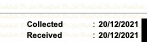

Label: Result


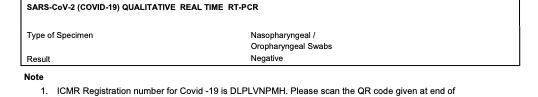

In [8]:
#take the first task and display the regions which are marked for regions
#get the first task
datadir="/home/venkat/.local/share/label-studio/media/upload/"
task=tasks[0]
#get the image path & read the image
firstTaskImgPath=os.path.join(datadir,str(task['project']),task['file_upload'])

im = Image.open(firstTaskImgPath)

for ulabel in userDefinedLabels:
    #crop image
    print("Label: "+ulabel['labelName'])
    im1 = im.crop((ulabel['x']/100*im.size[0], ulabel['y']/100*im.size[1], ulabel['x']/100*im.size[0]+ulabel['width']/100*im.size[0],ulabel['y']/100*im.size[1]+ulabel['height']/100*im.size[1]))
    display(im1)

    #do ocr
    #write as predictions of LS json


In [9]:
import pytesseract

os.environ["TESSDATA_PREFIX"] = '/home/venkat/Documents/ocr/tessdata/'



#some functions that will be called later
def ocr_image(input_image):
    tesseract_output = pytesseract.image_to_string(input_image)
    return tesseract_output

Provide the path containing input images(Relative to the current folder) data/samples


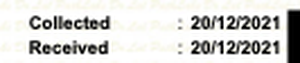

Name
Collected : 201272021
Received : 20M272021



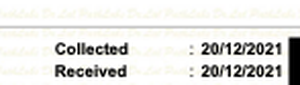

Colleced
Collected © 201212021
Received © 2011272021



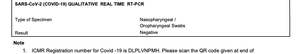

Result
 



In [10]:
#get the task. In this example we will get a folder that contains images for the current project
directory=input('Provide the path containing input images(Relative to the current folder)') or 'data/samples'

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and '.jpg' or '.png' in f:
        #read the image
        im = Image.open(f)
        #for each user defined labels
        for ulabel in userDefinedLabels:
            #crop image
            im1 = im.crop((ulabel['x']/100*im.size[0], ulabel['y']/100*im.size[1], ulabel['x']/100*im.size[0]+ulabel['width']/100*im.size[0],ulabel['y']/100*im.size[1]+ulabel['height']/100*im.size[1]))
            basewidth = 300
            
            wpercent = (basewidth/float(im1.size[0]))
            hsize = int((float(im1.size[1])*float(wpercent)))
            im1 = im1.resize((basewidth,hsize), Image.ANTIALIAS)
            #send it to ocr
            text=ocr_image(im1)
            display(im1)

            print(ulabel['labelName'])
            print(text)
            #write the json

        



#for each task
